# Docling Graph Extraction

Docling provides the capability of extracting information, i.e. structured data, from unstructured documents.

The user can provide the desired data schema AKA *template*, either as a Pydantic model, and Docling will return
the extracted data as a knowledge graph.

In [ ]:
%pip install -q docling[vlm]  # Install the Docling package with VLM support
%pip install pydantic rich

In [1]:
import os, sys
sys.path.append('.')  # Ensure current directory is in the path

from rich import print
from IPython import display

from pydantic import BaseModel, Field
from typing import Optional, List, Any

In this notebook, we will work with an example input image:

In [12]:
file_path = ("data/sample_invoice.jpg")
display.HTML(f"<img src='{file_path}' height='600'>")

## 1. Define the Docling Extractor Configuration

Let's first define our extractor:

In [13]:
from docling.datamodel.base_models import InputFormat
from docling.document_extractor import DocumentExtractor

extractor = DocumentExtractor(allowed_formats=[InputFormat.IMAGE, InputFormat.PDF])

## 2. Define the Pydantic Model Template

### 2.1. Load the Pydantic Model

You can create a new Pydantic model in the tempalte directory then load it here:

In [14]:
try:
    # Import the Invoice class from your new template file
    from templates.invoice import Invoice
    print("[bold green]Template 'Invoice' loaded successfully from templates/invoice.py[/bold green]")
    
except ImportError:
    print("[bold red]Error: Could not find 'templates/invoice.py'.[/bold red]")
    print("Please make sure the file exists in a 'templates' subfolder and that the notebook is running from the correct parent directory.")

except Exception as e:
    print(f"[bold red]An unexpected error occurred: {e}[/bold red]")

Template 'Invoice' loaded successfully from templates/invoice.py

### 2.2. Extract Information using Docling and the Pydantic Template

In [15]:
result = extractor.extract(
    source=file_path,
    template=Invoice,
)

print(result.pages)

c:\Users\Ayoub\miniconda3\envs\docling\Lib\site-packages\docling\document_extractor.py:143: UserWarning:

The extract API is currently experimental and may change without prior notice.
Only PDF and image formats are supported.



[
    ExtractedPageData(
        page_no=1,
        extracted_data={
            'bill_no': '3139',
            'date': '2020-07-01',
            'currency': 'CHF',
            'subtotal': 3667.35,
            'vat_rate': 7.7,
            'vat_amount': 282.4,
            'total': 3949.75,
            'issued_by': {
                'name': 'Robert Schneider AG',
                'phone': '059/987 6540',
                'email': 'robert@rschneider.ch',
                'website': 'www.rschneider.ch',
                'located_at': {
                    'street': 'Rue du Lac 1268',
                    'postal_code': '2501',
                    'city': 'Biel',
                    'country': None
                }
            },
            'sent_to': {
                'name': 'Pia Rutschmann',
                'lives_at': {
                    'street': 'Rue du Lac 1268',
                    'postal_code': '9400',
                    'city': 'Rorschach',
                    'country': None
                }
            },
            'contains_items': [
                {
                    'description': 'Garden work',
                    'quantity': 28.0,
                    'unit': 'pcs',
                    'unit_price': 307.35,
                    'total': 307.35
                },
                {
                    'description': 'Disposal of cuttings',
                    'quantity': 1.0,
                    'unit': 'pcs',
                    'unit_price': 307.35,
                    'total': 307.35
                }
            ]
        },
        raw_text='{"bill_no": "3139", "date": "2020-07-01", "currency": "CHF", "subtotal": 3667.35, "vat_rate": 
7.7, "vat_amount": 282.4, "total": 3949.75, "issued_by": {"name": "Robert Schneider AG", "phone": "059/987 6540", 
"email": "robert@rschneider.ch", "website": "www.rschneider.ch", "located_at": {"street": "Rue du Lac 1268", 
"postal_code": "2501", "city": "Biel", "country": null}}, "sent_to": {"name": "Pia Rutschmann", "lives_at": 
{"street": "Rue du Lac 1268", "postal_code": "9400", "city": "Rorschach", "country": null}}, "contains_items": 
[{"description": "Garden work", "quantity": 28.0, "unit": "pcs", "unit_price": 307.35, "total": 307.35}, 
{"description": "Disposal of cuttings", "quantity": 1.0, "unit": "pcs", "unit_price": 307.35, "total": 307.35}]}',
        errors=[]
    )
]

### 2.3. Validate and Load the Extracted Data

The generated response data can be easily validated and loaded via Pydantic:

In [16]:
invoice = Invoice.model_validate(result.pages[0].extracted_data)
print(invoice)

Invoice(
    bill_no='3139',
    date='2020-07-01',
    currency='CHF',
    subtotal=3667.35,
    vat_rate=7.7,
    vat_amount=282.4,
    total=3949.75,
    issued_by=Organization(
        name='Robert Schneider AG',
        phone='059/987 6540',
        email='robert@rschneider.ch',
        website='www.rschneider.ch',
        located_at=Address(street='Rue du Lac 1268', postal_code='2501', city='Biel', country=None)
    ),
    sent_to=Person(
        name='Pia Rutschmann',
        lives_at=Address(street='Rue du Lac 1268', postal_code='9400', city='Rorschach', country=None)
    ),
    contains_items=[
        LineItem(description='Garden work', quantity=28.0, unit='pcs', unit_price=307.35, total=307.35),
        LineItem(description='Disposal of cuttings', quantity=1.0, unit='pcs', unit_price=307.35, total=307.35)
    ]
)

## 3. Convert the Extracted Dictionary to a Graph

Takes the Pydantic model schema and the extracted data dictionary as input and outputs graph elements (nodes and edges) :

In [17]:
from scripts.graph_converter import GraphConverter
from scripts.graph_visualizer import create_static_graph, create_interactive_graph

# Instantiate the converter
converter = GraphConverter()

# Convert the populated 'invoice' object into a graph
knowledge_graph = converter.pydantic_to_graph(invoice)

print(
    "Graph conversion complete:\n"
    f"- Nodes: {knowledge_graph.number_of_nodes()}\n"
    f"- Edges: {knowledge_graph.number_of_edges()}"
)
print("[bold green]Knowledge graph created successfully.[/bold green]")

Graph conversion complete:
- Nodes: 7
- Edges: 6

Knowledge graph created successfully.

### 3.1. Display the Graph's Nodes and Edge in Plain Text

In [18]:
output = ["\n[bold green]--- Graph Elements Start ---[/bold green]\n"]

output.append("NODES (with properties):")
for node, data in knowledge_graph.nodes(data=True):
    output.append(f"  [{node}]")
    for key, value in data.items():
        output.append(f"    • {key}: {value}")
    output.append("")  # blank line between nodes

output.append("EDGES (with labels):")
for u, v, data in knowledge_graph.edges(data=True):
    label = data.get('label', '')
    output.append(f"  {u.split('_')[0]} → {v.split('_')[0]}   [{label}]")

output.append("\n[bold green]--- Graph Elements End ---[/bold green]\n")

print("\n".join(output))

--- Graph Elements Start ---

NODES (with properties):
  [Invoice_d2addcc965fe]
    • label: Invoice
    • bill_no: 3139
    • date: 2020-07-01
    • currency: CHF
    • subtotal: 3667.35
    • vat_rate: 7.7
    • vat_amount: 282.4
    • total: 3949.75

  [Organization_ddd75bddc1ce]
    • label: Organization
    • name: Robert Schneider AG
    • phone: 059/987 6540
    • email: robert@rschneider.ch
    • website: www.rschneider.ch

  [Address_03708c8bc2c7]
    • label: Address
    • street: Rue du Lac 1268
    • postal_code: 2501
    • city: Biel
    • country: None

  [Person_051b75614bc9]
    • label: Person
    • name: Pia Rutschmann

  [Address_023890830be5]
    • label: Address
    • street: Rue du Lac 1268
    • postal_code: 9400
    • city: Rorschach
    • country: None

  [LineItem_399a1f852c9d]
    • label: LineItem
    • description: Garden work
    • quantity: 28.0
    • unit: pcs
    • unit_price: 307.35
    • total: 307.35

  [LineItem_12d2422bfe5f]
    • label: LineItem
    • description: Disposal of cuttings
    • quantity: 1.0
    • unit: pcs
    • unit_price: 307.35
    • total: 307.35

EDGES (with labels):
  Invoice → Organization   [ISSUED_BY]
  Invoice → Person   [SENT_TO]
  Invoice → LineItem   [CONTAINS_ITEM]
  Invoice → LineItem   [CONTAINS_ITEM]
  Organization → Address   [LOCATED_AT]
  Person → Address   [LIVES_AT]

--- Graph Elements End ---

### 3.2. Draw and Save the Graph as an Image

Using 'graphviz' for a hierarchical layout.


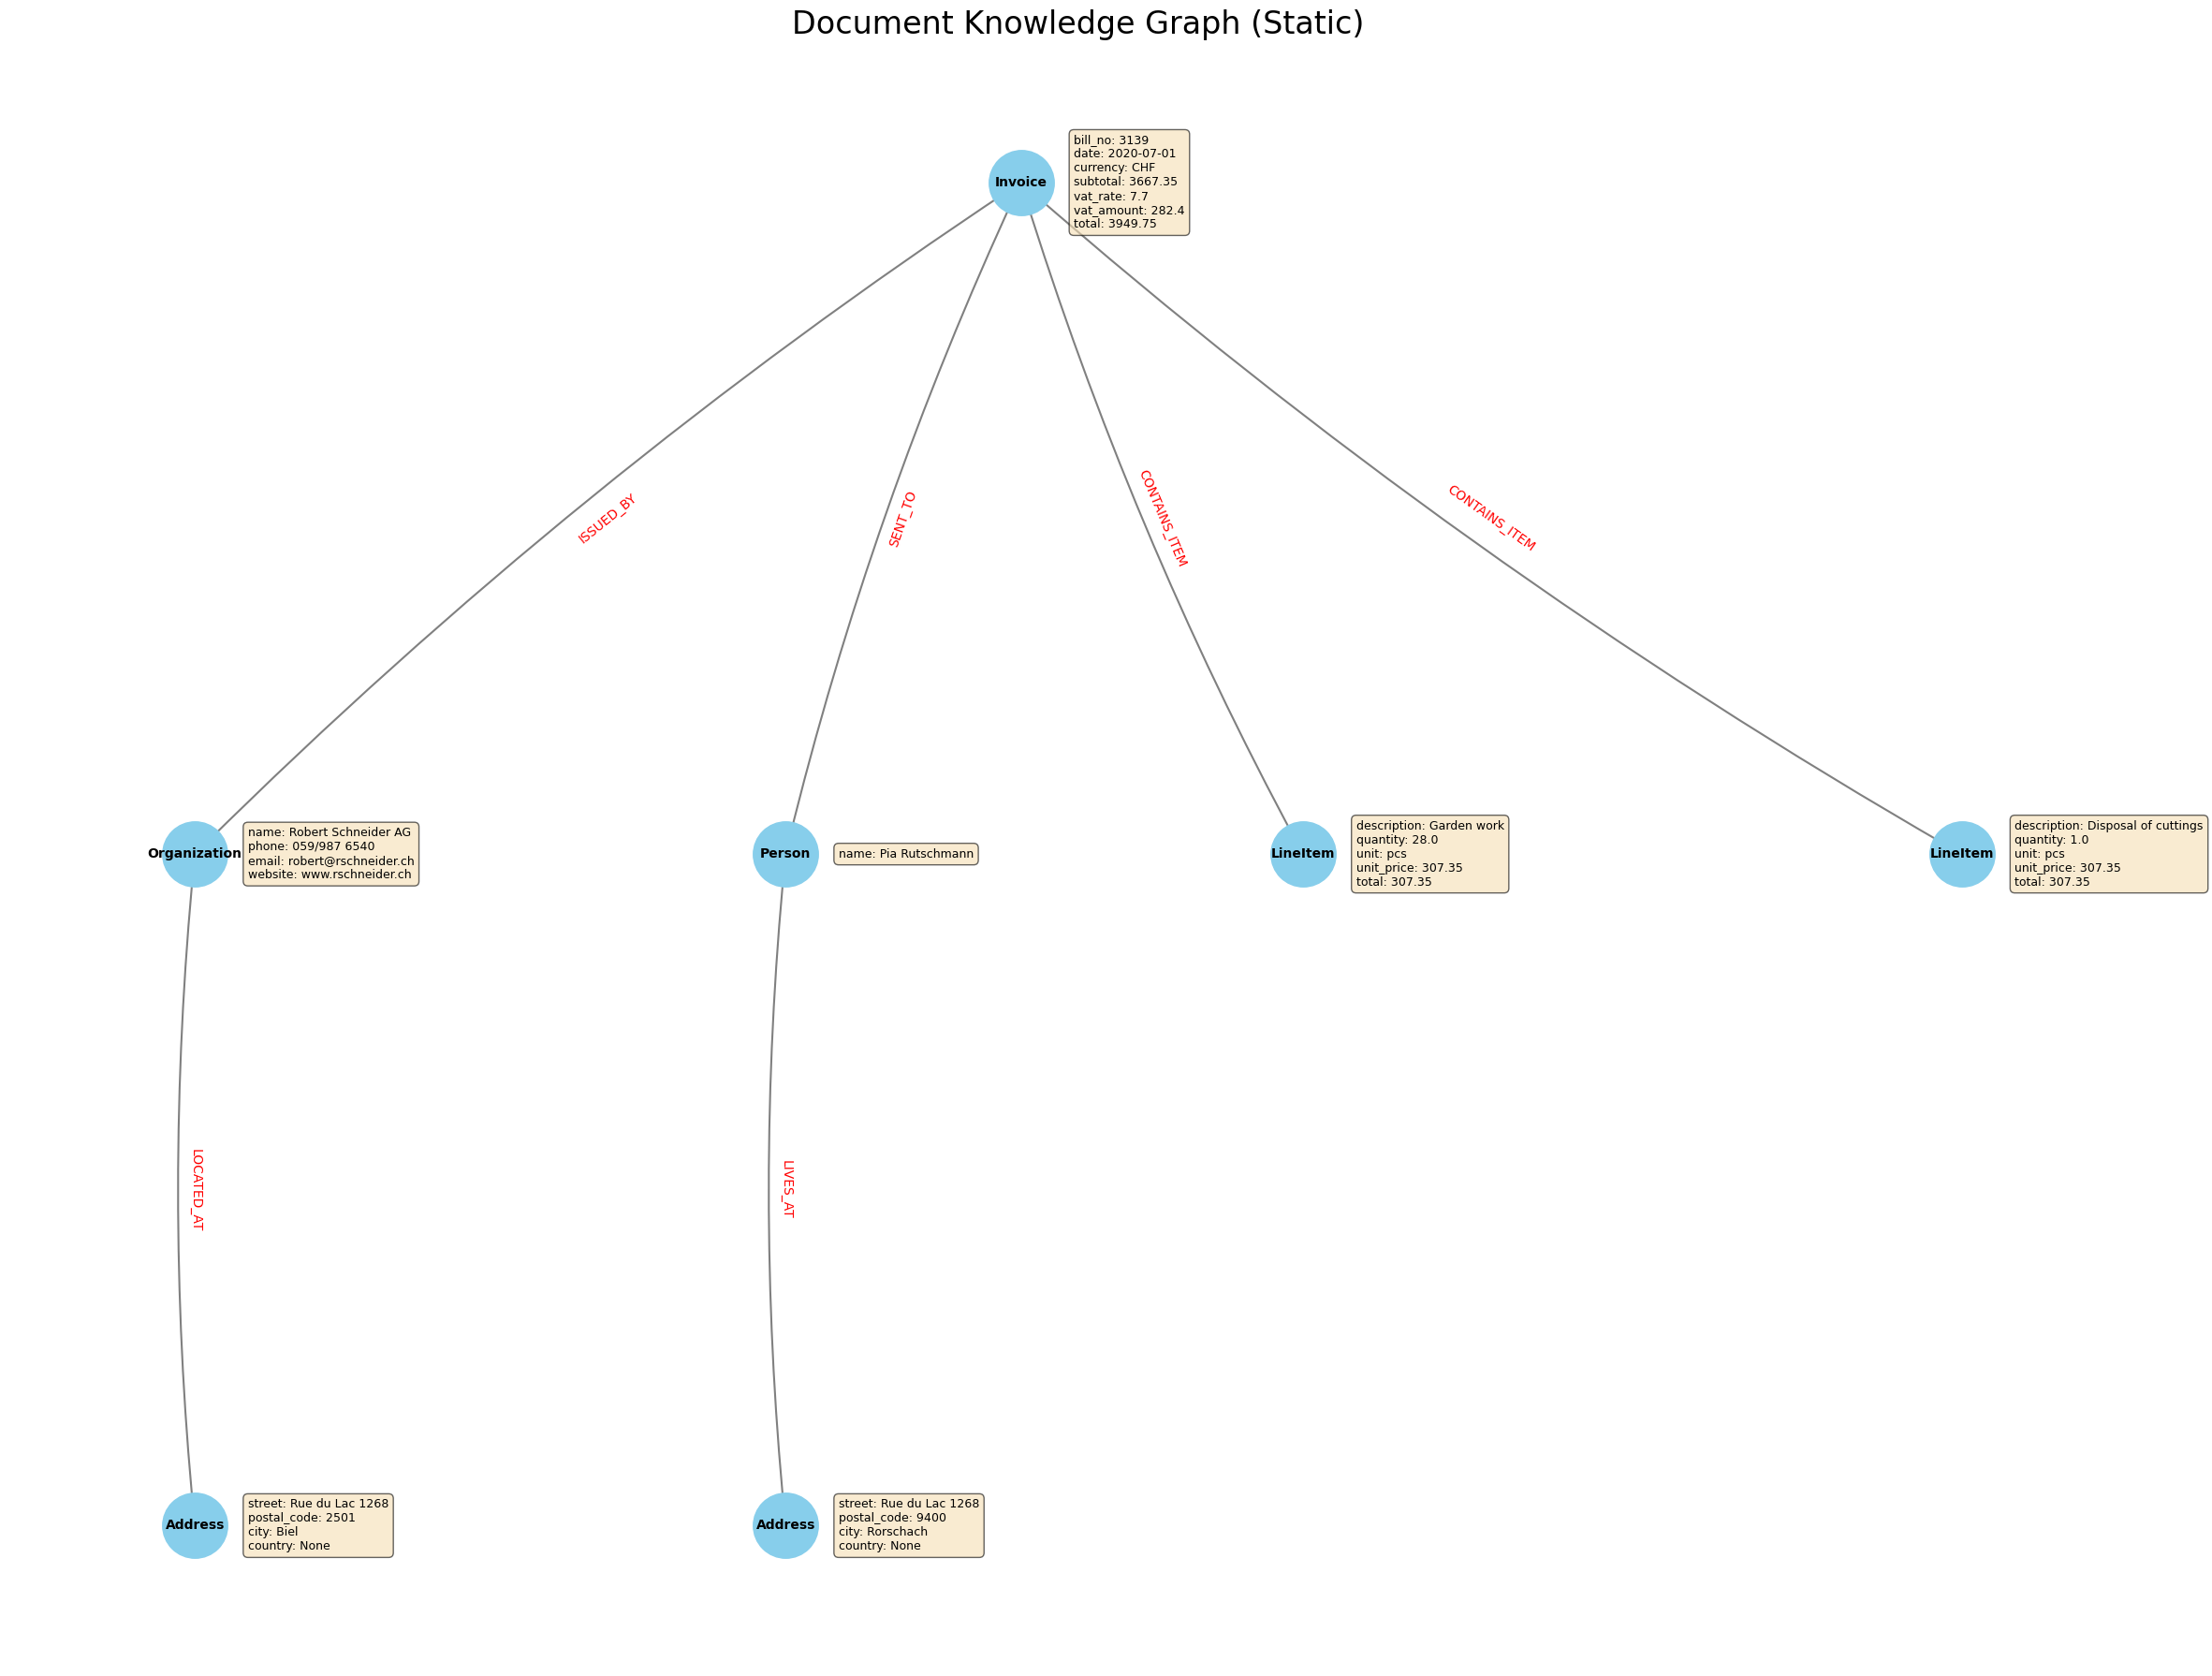

Static graph with properties saved to outputs\invoice_knowledge_graph.png


Graph image created successfully.

In [19]:
# Draw the graph and save it to a file
static_image_file = "invoice_knowledge_graph.png"
create_static_graph(knowledge_graph, filename=static_image_file)
print("[bold green]Graph image created successfully.[/bold green]")

### 3.3. Generate Interactive Visualization with Plotly

In [20]:
# Create an Interactive Visualization with PyVis
interactive_html_file = "invoice_graph_interactive.html"
html_path = create_interactive_graph(knowledge_graph, filename=interactive_html_file)
print("[bold green]Interactive graph created successfully.[/bold green]")

Interactive Plotly graph saved to: outputs\invoice_graph_interactive.html


Interactive graph created successfully.